# Data Exploration

Preprocessing steps which we could take:

- Remove/check 'R_A' , 'R_V' and 'R' from `ACTIVITY_TYPE`. Very few occurences, not sure what they represent (maybe ask first).
- Remove 'NB', 'VB' and 'VST' from `TRAINSERIE_DIRECTION`. Same story as above.
- Remove 'MS' from `ROLLINGSTOCK_TYPE`,  NS people said this train was not relevant.
- Change `SPLIT` and `COMBINE` to a binary value.
- Give `ROLLINGSTOCK_TYPE` and `STATION` categorical labels. Not required for all ML models I guess
- Remove rows where `TURNOVER_TIME` is larger than 1 hour or shorter than a minute.
- Remove rows where `DEPARTURE_SIGNAL_SHOW_SAFE` is larger than `PLAN_DATETIME`. From last meeting, to ensure that trunover times are not inflated by holdups on the track.
- Remove rows where `DELAY` is larger than x or smaller than x.
- Normalize numerical values: `DELAY` 

In [1]:
from time import time
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from utils import preprocessing as prep


In [2]:
import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

## 1. Load Data

Load the full dataset:

In [41]:
df_full = pd.read_csv('Data.csv', low_memory = False) # Only for comparison and visualisation

In [42]:
df = prep.set_types(df_full)

In [43]:
turnover_df = prep.calc_turnover(df)

C:\Users\Gebruiker\Documents\CODE\Master\Thesis\utils\preprocessing.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nan["PLAN_TURNOVER_TIME"] = plan_turnover_time
C:\Users\Gebruiker\Documents\CODE\Master\Thesis\utils\preprocessing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nan["REALIZED_TURNOVER_TIME"] = real_turnover_time
C:\Users\Gebruiker\Documents\CODE\Master\Thesis\utils\preprocessing.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

In [44]:
turnover_df["PLAN_SIGNAL_SAFE_DELAY"] = (turnover_df["DEPARTURE_SIGNAL_SHOWS_SAFE"] - turnover_df["PLAN_DATETIME"]).dt.total_seconds()
turnover_df["REALIZED_SIGNAL_SAFE_DELAY"] = (turnover_df["DEPARTURE_SIGNAL_SHOWS_SAFE"] - turnover_df["REALIZED_DATETIME"]).dt.total_seconds()

Transform `COMBINE`and `SPLIT` into binary values, removing NaN values in the proces:

In [7]:
turnover_df['COMBINE'] = turnover_df['COMBINE'].notna().astype(int)
df_full['COMBINE'] = df_full['COMBINE'].notna().astype(int)

turnover_df['SPLIT'] = turnover_df['SPLIT'].notna().astype(int)
df_full['SPLIT'] = df_full['SPLIT'].notna().astype(int)


In [8]:
turnover_df = turnover_df[(turnover_df["PLAN_TURNOVER_TIME"] >= 30) & (turnover_df["PLAN_TURNOVER_TIME"] <= 6000)]
turnover_df = turnover_df[(turnover_df["DELAY"] >= -600) & (turnover_df["DELAY"] <= 10000)]

## 2. Data Exploration

Text(0, 0.5, 'Delay (seconds)')

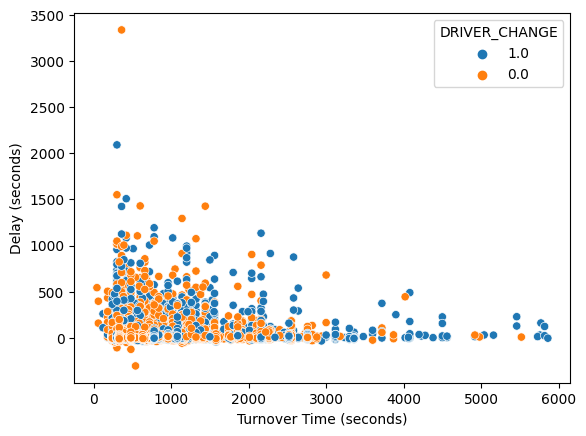

In [9]:
fig = sns.scatterplot(turnover_df, x="PLAN_TURNOVER_TIME", y="DELAY", hue = "DRIVER_CHANGE")

fig.get_xaxis().set_label_text('Turnover Time (seconds)')
fig.get_yaxis().set_label_text('Delay (seconds)')

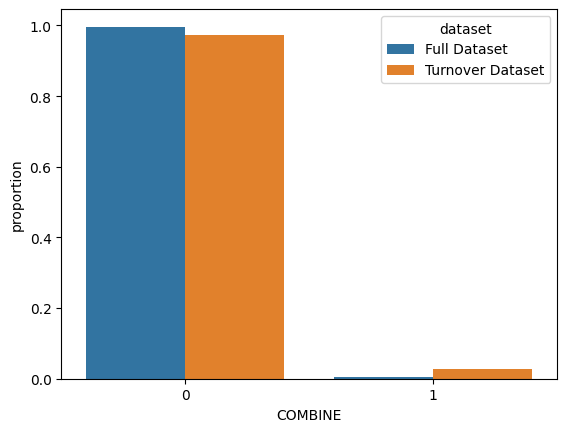

In [10]:
# Calculate proportions for the full dataset
full_counts = df_full['COMBINE'].value_counts(normalize=True).reset_index()
full_counts.columns = ['COMBINE', 'proportion']
full_counts['dataset'] = 'Full Dataset'

# Calculate proportions for the subset
turnover_counts = turnover_df['COMBINE'].value_counts(normalize=True).reset_index()
turnover_counts.columns = ['COMBINE', 'proportion']
turnover_counts['dataset'] = 'Turnover Dataset'

# Combine the two datasets
combined_data = pd.concat([full_counts, turnover_counts])

sns.barplot(combined_data, x='COMBINE',y = 'proportion', hue = "dataset")
plt.show()

<Axes: xlabel='SPLIT', ylabel='proportion'>

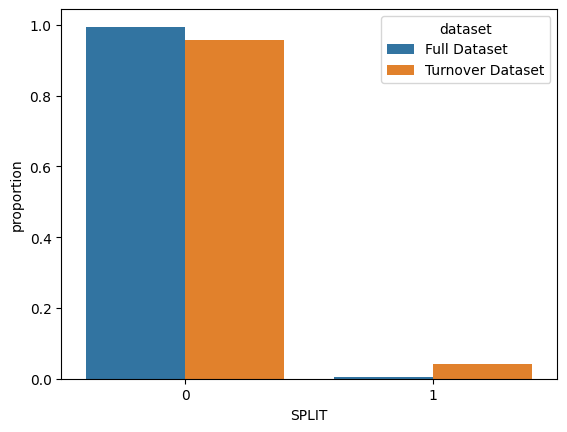

In [11]:
# Calculate proportions for the full dataset
full_counts = df_full['SPLIT'].value_counts(normalize=True).reset_index()
full_counts.columns = ['SPLIT', 'proportion']
full_counts['dataset'] = 'Full Dataset'

# Calculate proportions for the subset
turnover_counts = turnover_df['SPLIT'].value_counts(normalize=True).reset_index()
turnover_counts.columns = ['SPLIT', 'proportion']
turnover_counts['dataset'] = 'Turnover Dataset'


# Combine the two datasets
combined_data = pd.concat([full_counts, turnover_counts])
sns.barplot(combined_data, x = "SPLIT", y = 'proportion', hue = 'dataset')

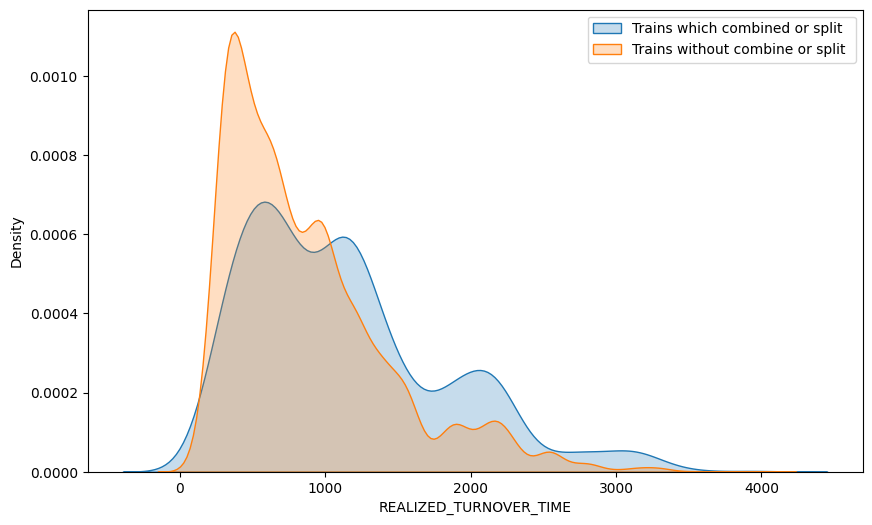

In [12]:
# Limit Turnover time
temp_df = turnover_df
temp_df = temp_df.loc[temp_df["REALIZED_TURNOVER_TIME"] < 4000]


# Create separate dataframes for combined/split trains
combine_and_split = temp_df[(temp_df["COMBINE"] == 1) | (temp_df["SPLIT"] == 1)]
no_combine_or_split = temp_df[(temp_df["COMBINE"] == 0) & (temp_df["SPLIT"] == 0)]
                                  
plt.figure(figsize=(10, 6))
sns.kdeplot(data=combine_and_split['REALIZED_TURNOVER_TIME'], label='Trains which combined or split', fill=True)
sns.kdeplot(data=no_combine_or_split['REALIZED_TURNOVER_TIME'], label='Trains without combine or split ', fill=True)

plt.xlabel('REALIZED_TURNOVER_TIME')
plt.ylabel('Density')
plt.legend()
plt.show()

### Signal Safe Delay

In [49]:
turnover_df["PLAN_SIGNAL_SAFE_DELAY"].range()

AttributeError: 'Series' object has no attribute 'range'

In [13]:
turnover_df = turnover_df.loc[turnover_df["PLAN_SIGNAL_SAFE_DELAY"] < 10]

<Axes: xlabel='PLAN_SIGNAL_SAFE_DELAY', ylabel='Count'>

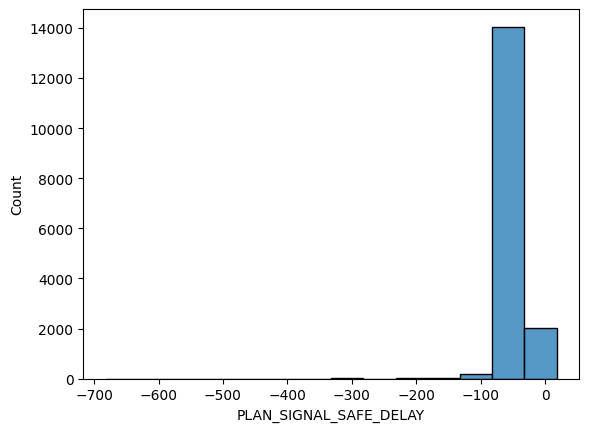

In [14]:
sns.histplot(turnover_df, x = "PLAN_SIGNAL_SAFE_DELAY", binwidth = 50)

### Rollings Stock Type

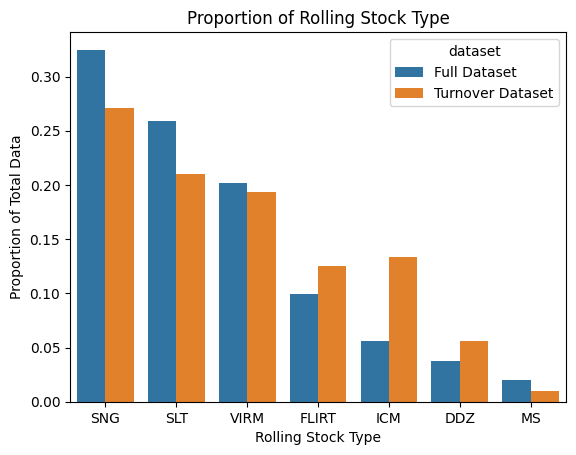

In [15]:
# Calculate proportions for the full dataset
full_counts = df_full['ROLLINGSTOCK_TYPE'].value_counts(normalize=True).reset_index()
full_counts.columns = ['ROLLINGSTOCK_TYPE', 'proportion']
full_counts['dataset'] = 'Full Dataset'

# Calculate proportions for the subset
turnover_counts = turnover_df['ROLLINGSTOCK_TYPE'].value_counts(normalize=True).reset_index()
turnover_counts.columns = ['ROLLINGSTOCK_TYPE', 'proportion']
turnover_counts['dataset'] = 'Turnover Dataset'

# Combine the two datasets
combined_data = pd.concat([full_counts, turnover_counts])

# Create a barplot to show proportions
order = df_full['ROLLINGSTOCK_TYPE'].value_counts().index

sns.barplot(data=combined_data, x='ROLLINGSTOCK_TYPE', y='proportion', hue='dataset', order=order)

plt.title('Proportion of Rolling Stock Type')
plt.xlabel('Rolling Stock Type')
plt.ylabel('Proportion of Total Data')

plt.show()

<Axes: xlabel='PLAN_TURNOVER_TIME', ylabel='ROLLINGSTOCK_TYPE'>

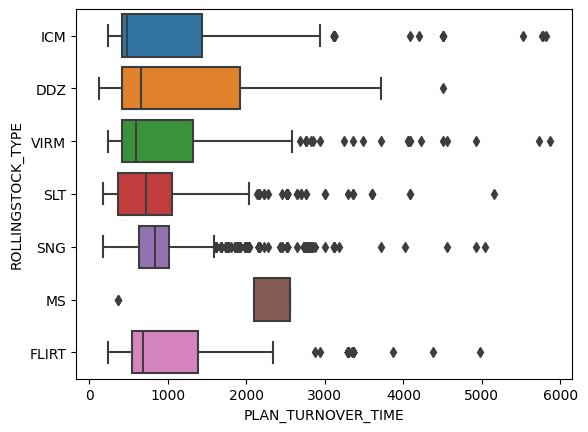

In [16]:
sns.boxplot(turnover_df, x = "PLAN_TURNOVER_TIME",y = "ROLLINGSTOCK_TYPE")

Some rollingstock types are influenced more by combining and splitting than others:

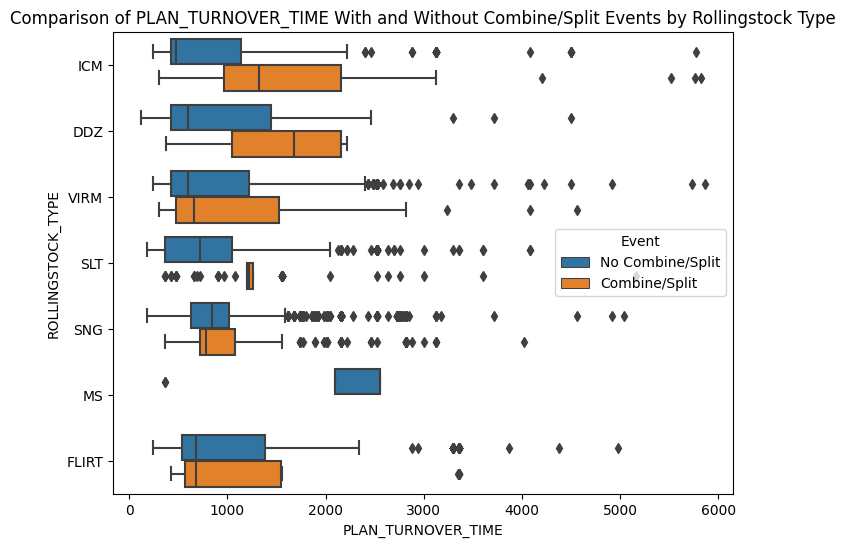

In [17]:
temp_df = turnover_df
temp_df['Event'] = np.where((temp_df['COMBINE'] == 1) | (temp_df['SPLIT'] == 1), 'Combine/Split', 'No Combine/Split')


plt.figure(figsize=(8, 6))
sns.boxplot(data=temp_df, x='PLAN_TURNOVER_TIME', y='ROLLINGSTOCK_TYPE', hue='Event')
plt.title('Comparison of PLAN_TURNOVER_TIME With and Without Combine/Split Events by Rollingstock Type')
plt.show()

### Activity Types

<Axes: xlabel='ACTIVITYTYPE', ylabel='count'>

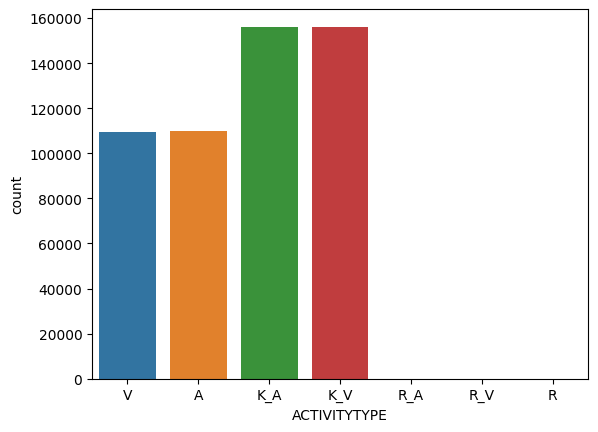

In [18]:
sns.countplot(df_full, x = "ACTIVITYTYPE")

<Axes: xlabel='TRAINSERIE_DIRECTION', ylabel='count'>

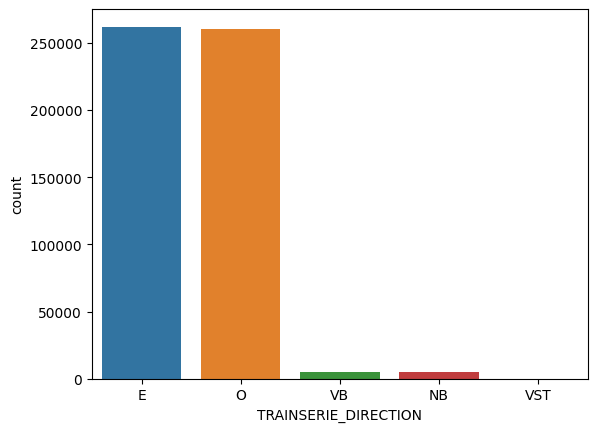

In [19]:
sns.countplot(df_full, x = "TRAINSERIE_DIRECTION")

### Stations

The turnover data has 83 unique stations
The regular data has 292 unique stations


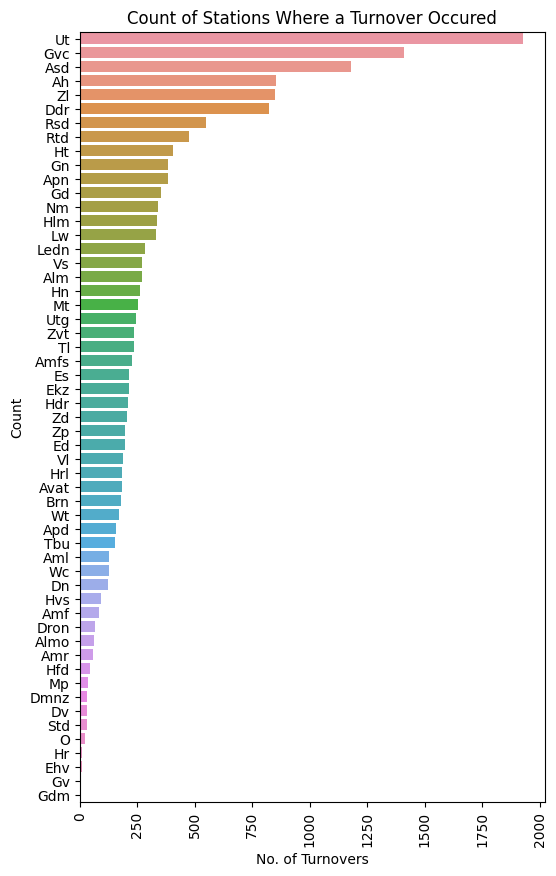

In [20]:
order = turnover_df['STATION'].value_counts().nlargest(55).index

# Inrease the figure size
plt.figure(figsize=(6, 10))  

sns.countplot(turnover_df, y = "STATION", order=order)

plt.title('Count of Stations Where a Turnover Occured')
plt.xlabel('No. of Turnovers')
plt.ylabel('Count')

plt.xticks(rotation=90)  # Rotate labels to avoid overlap

print('The turnover data has {} unique stations'.format(len(turnover_df['STATION'].unique())))
print('The regular data has {} unique stations'.format(len(df_full['STATION'].unique())))

plt.show()

In [21]:
stations_in_turnover = set(turnover_df['STATION'])

df['IN_TURNOVER'] = df['STATION'].isin(stations_in_turnover).astype(int)


(array([    0.,  2000.,  4000.,  6000.,  8000., 10000., 12000., 14000.,
        16000.]),
 [Text(0.0, 0, '0'),
  Text(2000.0, 0, '2000'),
  Text(4000.0, 0, '4000'),
  Text(6000.0, 0, '6000'),
  Text(8000.0, 0, '8000'),
  Text(10000.0, 0, '10000'),
  Text(12000.0, 0, '12000'),
  Text(14000.0, 0, '14000'),
  Text(16000.0, 0, '16000')])

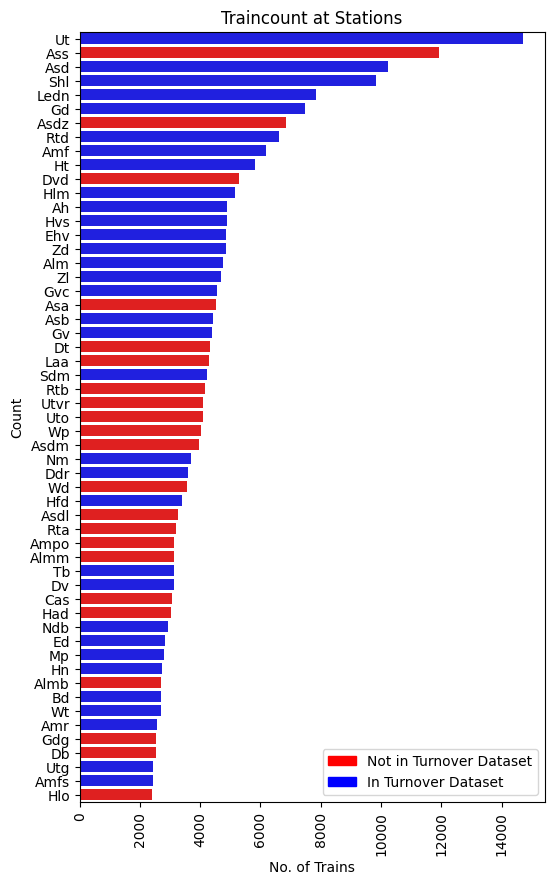

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

# Define color map
color_map = {0: 'red', 1: 'blue'}

# Sort in size
order = df['STATION'].value_counts().nlargest(55).index

plt.figure(figsize=(6, 10))  

# Calculate counts
station_counts = df['STATION'].value_counts().loc[order]
colors = df.drop_duplicates(subset=['STATION']).set_index('STATION')['IN_TURNOVER'].map({0: 'red', 1: 'blue'}).reindex(order)

sns.barplot(y=station_counts.index, x=station_counts.values, palette=colors)

# Create legend patches
legend_patches = [mpatches.Patch(color=color_map[key], label=f'{"In Turnover Dataset" if key else "Not in Turnover Dataset"}') for key in color_map]

# Add legend to plot
plt.legend(handles=legend_patches)
plt.title('Traincount at Stations')
plt.xlabel('No. of Trains')
plt.ylabel('Count')
plt.xticks(rotation=90)  


### Effect of Rolling Stock Length

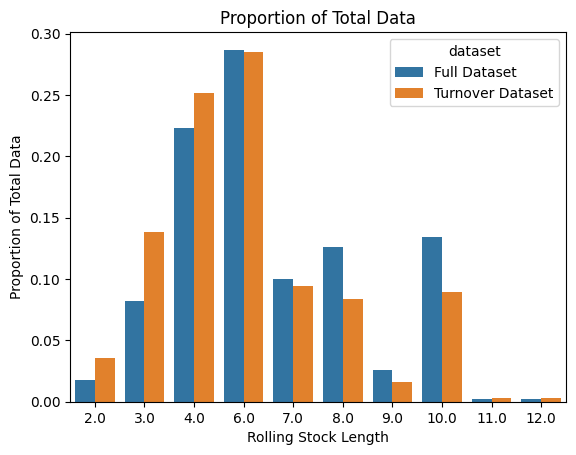

In [23]:
# Calculate proportions for the full dataset
full_counts = df_full['NUMBER_CARRIAGES'].value_counts(normalize=True).reset_index()
full_counts.columns = ['NUMBER_CARRIAGES', 'proportion']
full_counts['dataset'] = 'Full Dataset'

# Calculate proportions for the subset
turnover_counts = turnover_df['NUMBER_CARRIAGES'].value_counts(normalize=True).reset_index()
turnover_counts.columns = ['NUMBER_CARRIAGES', 'proportion']
turnover_counts['dataset'] = 'Turnover Dataset'

# Combine the two datasets
combined_data = pd.concat([full_counts, turnover_counts])

sns.barplot(data=combined_data, x='NUMBER_CARRIAGES', y='proportion', hue='dataset')

plt.title('Proportion of Total Data')
plt.xlabel('Rolling Stock Length')
plt.ylabel('Proportion of Total Data')

plt.show()

On average, the turnover time seems to decrease with an increase in cariages.

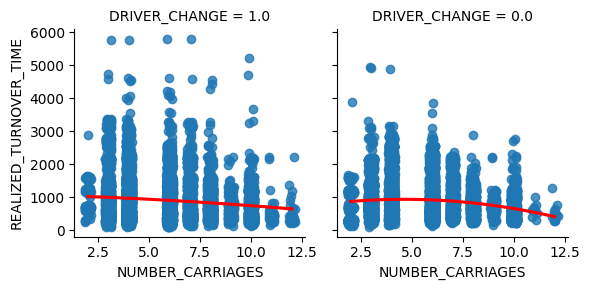

In [24]:
g = sns.FacetGrid(turnover_df, col="DRIVER_CHANGE")  

g.map(sns.regplot, "NUMBER_CARRIAGES", "REALIZED_TURNOVER_TIME", order=2, x_jitter=.15, line_kws={'color': 'red'})

plt.show()

### Effect of Driver Change

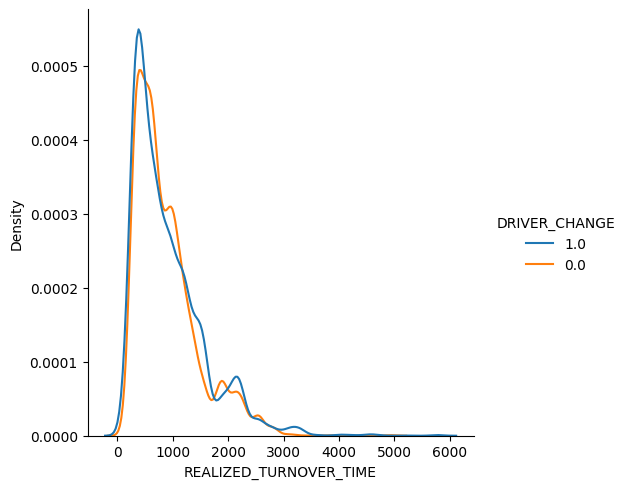

In [25]:
sns.displot(turnover_df, x = "REALIZED_TURNOVER_TIME", hue = "DRIVER_CHANGE", kind = 'kde')

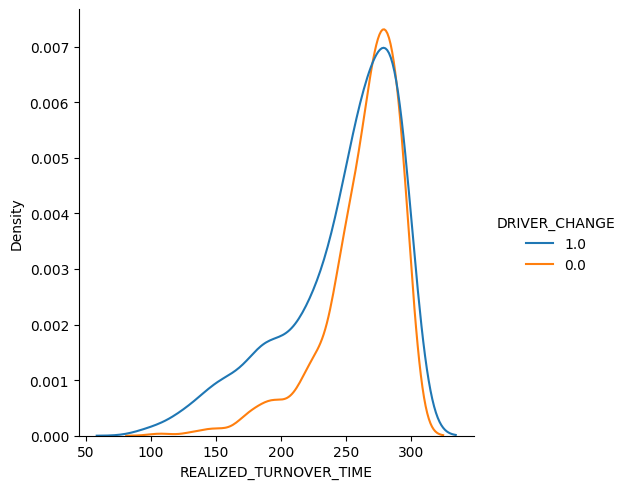

In [26]:
short_turnover_df = turnover_df[turnover_df["REALIZED_TURNOVER_TIME"] < 300]
sns.displot(short_turnover_df, x = "REALIZED_TURNOVER_TIME", hue = "DRIVER_CHANGE", kind = 'kde')

A driver change only has a positive impact when the planned turnover time is short, otherwise it has a negative impact on turnover time:

In [27]:
print('Short turnovers (5 minutes or less):', )
print(short_turnover_df.groupby('DRIVER_CHANGE')['REALIZED_TURNOVER_TIME'].mean())


long_turnover_df = turnover_df[turnover_df["REALIZED_TURNOVER_TIME"] > 900]
print()
print('Long turnovers (15 minutes or more):', )
print(long_turnover_df.groupby('DRIVER_CHANGE')['REALIZED_TURNOVER_TIME'].mean())



Short turnovers (5 minutes or less):
DRIVER_CHANGE
0.0    262.903704
1.0    247.556441
Name: REALIZED_TURNOVER_TIME, dtype: float64

Long turnovers (15 minutes or more):
DRIVER_CHANGE
0.0    1433.688882
1.0    1517.246543
Name: REALIZED_TURNOVER_TIME, dtype: float64


Driver changes are more likely to occur when a turnover happens as well:

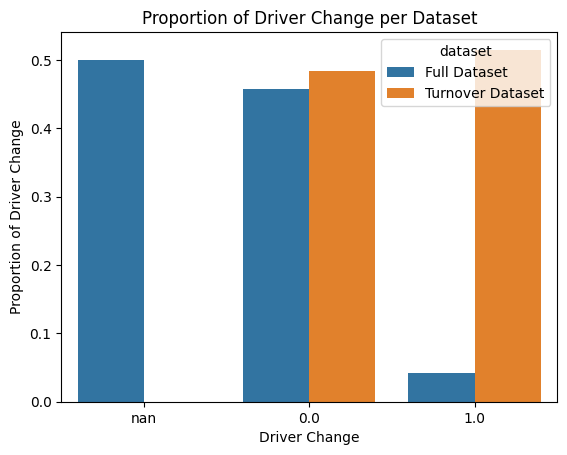

In [28]:
# Calculate proportions for the full dataset
full_counts = df_full['DRIVER_CHANGE'].value_counts(normalize=True).reset_index()
full_counts.columns = ['DRIVER_CHANGE', 'proportion']
full_counts['dataset'] = 'Full Dataset'

# Calculate proportions for the subset
turnover_counts = turnover_df['DRIVER_CHANGE'].value_counts(normalize=True).reset_index()
turnover_counts.columns = ['DRIVER_CHANGE', 'proportion']
turnover_counts['dataset'] = 'Turnover Dataset'

# Combine the two datasets
combined_data = pd.concat([full_counts, turnover_counts])

# Create a barplot to show proportions
order = df_full['DRIVER_CHANGE'].value_counts().index

sns.barplot(data=combined_data, x='DRIVER_CHANGE', y='proportion', hue='dataset', order=order)

plt.title('Proportion of Driver Change per Dataset')
plt.xlabel('Driver Change')
plt.ylabel('Proportion of Driver Change')

plt.show()

## 3. Linear Model: Complete Dataset

In [29]:
le = LabelEncoder()
turnover_df['STATION_CODE'] = le.fit_transform(turnover_df['STATION'])

stations = ['Ut', 'Gvc', 'Asd', 'Ah', 'Zl', 'Ddr']
if ({'Ut', 'Gvc', 'Asd', 'Ah', 'Zl', 'Ddr'}.issubset(turnover_df.columns)):
    print('Columns already added')
else: 
    temp = turnover_df[turnover_df["STATION"].isin(stations)]
    dummy_codes = pd.get_dummies(temp["STATION"])
    turnover_df = pd.concat([temp, dummy_codes], axis = 'columns')
    

In [30]:
if ({'SLT', 'SNG', 'VIRM', 'DDZ', 'FLIRT', 'ICM', 'SLT', 'SNG', 'VIRM'}.issubset(turnover_df.columns)):
    print('Columns already added')
else: 
    dummy_codes = pd.get_dummies(turnover_df["ROLLINGSTOCK_TYPE"])
    turnover_df = pd.concat([turnover_df, dummy_codes], axis = 'columns')
    turnover_df.head()

In [31]:
turnover_df

,TRAFFIC_DATE,TRAINNUMBER,TRAINSERIE,TRAINSERIE_DIRECTION,STATION,ACTIVITYTYPE,PLAN_DATETIME,REALIZED_DATETIME,DELAY,TURNOVER_INDICATOR,...,REALIZED_SIGNAL_SAFE_DELAY,Event,STATION_CODE,DDZ,FLIRT,ICM,MS,SLT,SNG,VIRM
40,2023-03-06,519,500.0,O,Ut,V,2023-03-06 06:49:00+00:00,2023-03-06 06:49:38+00:00,38.0,1,...,-91.0,No Combine/Split,70,False,False,True,False,False,False,False
66,2023-03-06,520,500.0,E,Ut,V,2023-03-06 08:18:00+00:00,2023-03-06 08:18:29+00:00,29.0,1,...,-81.0,No Combine/Split,70,False,False,True,False,False,False,False
78,2023-03-06,523,500.0,O,Ut,V,2023-03-06 07:49:00+00:00,2023-03-06 07:48:58+00:00,-2.0,1,...,-50.0,No Combine/Split,70,False,False,True,False,False,False,False
94,2023-03-06,524,500.0,E,Ut,V,2023-03-06 09:18:00+00:00,2023-03-06 09:18:04+00:00,4.0,1,...,-57.0,No Combine/Split,70,True,False,False,False,False,False,False
106,2023-03-06,527,500.0,O,Ut,V,2023-03-06 08:49:00+00:00,2023-03-06 08:49:15+00:00,15.0,1,...,-68.0,No Combine/Split,70,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
531713,2023-03-12,704682,700000.0,E,Zl,V,2023-03-12 22:37:00+00:00,2023-03-12 22:37:06+00:00,6.0,1,...,-61.0,No Combine/Split,80,False,False,False,False,False,True,False
531717,2023-03-12,704683,700000.0,O,Dron,V,2023-03-12 23:36:06+00:00,2023-03-12 23:35:55+00:00,-11.0,1,...,-43.0,No Combine/Split,23,False,False,False,False,False,True,False
531721,2023-03-12,704684,700000.0,E,Zl,V,2023-03-12 23:07:00+00:00,2023-03-12 23:06:57+00:00,-3.0,1,...,-52.0,No Combine/Split,80,False,False,False,False,False,True,False
531725,2023-03-12,704685,700000.0,O,Dron,V,2023-03-13 00:06:06+00:00,2023-03-13 00:05:57+00:00,-9.0,1,...,-43.0,No Combine/Split,23,False,False,False,False,False,True,False


In [32]:
# Selecting the relevant columns for the regression analysis
relevant_data = turnover_df[['SLT', 'SNG', 'VIRM', 'DDZ', 'FLIRT', 'ICM', 'SLT', 'SNG', 'VIRM', 'SPLIT', 'COMBINE', 'NUMBER_CARRIAGES', 'DRIVER_CHANGE', 'PLAN_TURNOVER_TIME']]
X = relevant_data.drop('PLAN_TURNOVER_TIME', axis=1)
y = relevant_data['PLAN_TURNOVER_TIME']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

model = LinearRegression()

# Fit the model
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
coefficients = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])

print('RMSE: ', rmse)
print('R2: ', r2) 
print(coefficients)


RMSE:  589.9744772773495
R2:  0.10709701132916538
                  Coefficient
SLT               -773.160858
SNG               -729.281812
VIRM              -736.016442
DDZ              -1362.997650
FLIRT            -1425.649214
ICM              -1460.209614
SLT               -773.160858
SNG               -729.281812
VIRM              -736.016442
SPLIT              347.381156
COMBINE            273.848838
NUMBER_CARRIAGES   -16.676270
DRIVER_CHANGE       40.386983


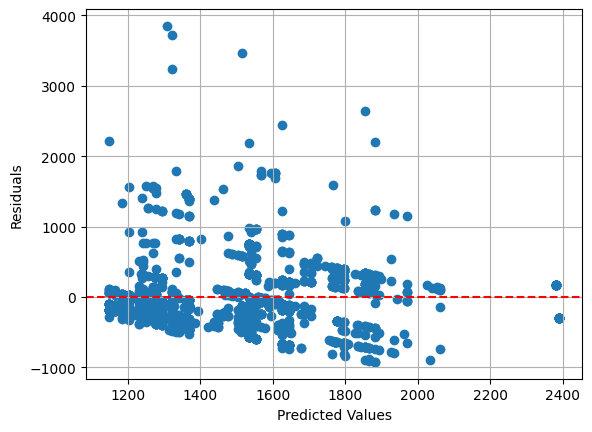

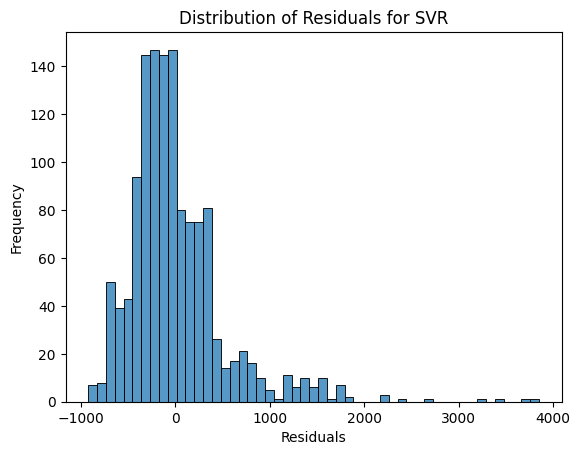

In [40]:
# Calculate residuals
residuals = y_test - y_pred

# Plotting residuals
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='red', linestyle='--')
plt.grid(True)
plt.show()

# Checking for normality of residuals
sns.histplot(residuals)
plt.title('Distribution of Residuals for SVR')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

## 4. Linear Model: Segemented Dataset

In [34]:
short_turnover = turnover_df[turnover_df["REALIZED_TURNOVER_TIME"] <= 300]
medium_turnover = turnover_df[(turnover_df["REALIZED_TURNOVER_TIME"] > 300) & (turnover_df["REALIZED_TURNOVER_TIME"] < 900)]
large_turnover = turnover_df[turnover_df["REALIZED_TURNOVER_TIME"] >= 900]

RMSE:  111.17538144054181
R2:  -0.008628369254436219
                  Coefficient
SLT                -51.820556
SNG                 51.437441
VIRM                26.293848
DDZ                 22.530362
FLIRT              -52.455238
ICM                  4.014144
SPLIT               51.619355
COMBINE             17.008082
NUMBER_CARRIAGES     4.673068
DRIVER_CHANGE      -52.793789
STATION_CODE         0.276610


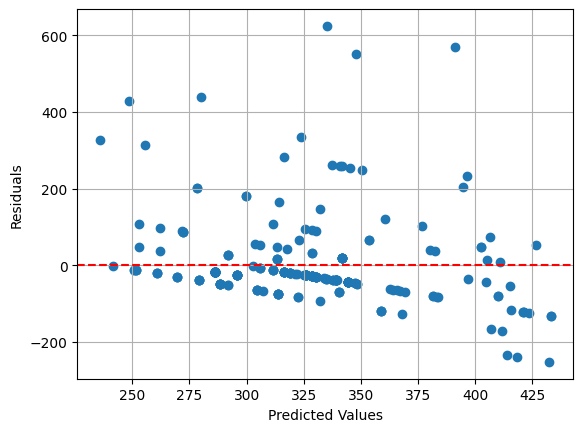

In [35]:
# Selecting the relevant columns for the regression analysis
relevant_data = short_turnover[['SLT', 'SNG', 'VIRM', 'DDZ', 'FLIRT', 'ICM', 'SPLIT', 'COMBINE', 'NUMBER_CARRIAGES', 'DRIVER_CHANGE', 'PLAN_TURNOVER_TIME', "STATION_CODE"]]
X = relevant_data.drop('PLAN_TURNOVER_TIME', axis=1)
y = relevant_data['PLAN_TURNOVER_TIME']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

model = LinearRegression()

# Fit the model
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
coefficients = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])

print('RMSE: ', rmse)
print('R2: ', r2) 
print(coefficients)

# Calculate residuals
residuals = y_test - y_pred

# Plotting residuals
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='red', linestyle='--')
plt.grid(True)
plt.show()

RMSE:  191.4737739735809
R2:  0.12910856764833534
                  Coefficient
SLT                223.565646
SNG                304.061058
VIRM               157.413139
DDZ                168.831584
FLIRT              205.271944
ICM                125.848672
SPLIT               90.569978
COMBINE             28.053365
NUMBER_CARRIAGES    -1.876056
DRIVER_CHANGE       -9.353913


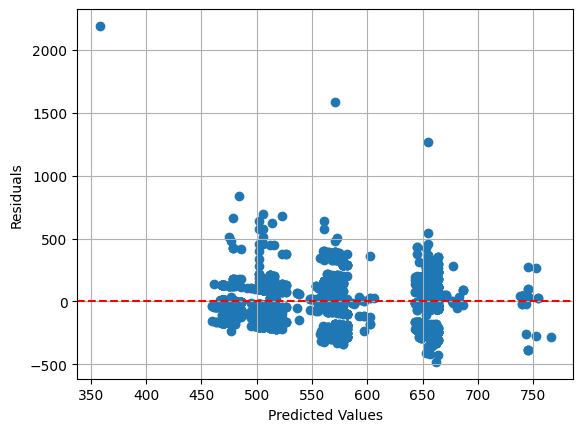

In [36]:
# Selecting the relevant columns for the regression analysis
relevant_data = medium_turnover[['SLT', 'SNG', 'VIRM', 'DDZ', 'FLIRT', 'ICM', 'SPLIT', 'COMBINE', 'NUMBER_CARRIAGES', 'DRIVER_CHANGE', 'PLAN_TURNOVER_TIME']]
X = relevant_data.drop('PLAN_TURNOVER_TIME', axis=1)
y = relevant_data['PLAN_TURNOVER_TIME']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

model = LinearRegression()

# Fit the model
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
coefficients = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])

print('RMSE: ', rmse)
print('R2: ', r2) 
print(coefficients)

# Calculate residuals
residuals = y_test - y_pred

# Plotting residuals
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='red', linestyle='--')
plt.grid(True)
plt.show()

RMSE:  521.0913029935207
R2:  0.20055412153242314
                  Coefficient
SLT              -1180.562537
SNG              -1114.495838
VIRM              -829.760855
DDZ               -676.899637
FLIRT             -877.796611
ICM               -591.017288
SPLIT              170.192599
COMBINE             71.387973
NUMBER_CARRIAGES    -9.235831
DRIVER_CHANGE       91.331291


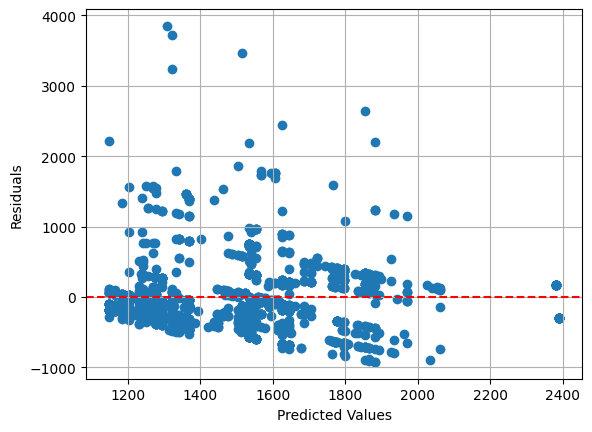

In [37]:
# Selecting the relevant columns for the regression analysis
relevant_data = large_turnover[['SLT', 'SNG', 'VIRM', 'DDZ', 'FLIRT', 'ICM', 'SPLIT', 'COMBINE', 'NUMBER_CARRIAGES', 'DRIVER_CHANGE', 'PLAN_TURNOVER_TIME']]
X = relevant_data.drop('PLAN_TURNOVER_TIME', axis=1)
y = relevant_data['PLAN_TURNOVER_TIME']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

model = LinearRegression()

# Fit the model
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
coefficients = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])

print('RMSE: ', rmse)
print('R2: ', r2) 
print(coefficients)

# Calculate residuals
residuals = y_test - y_pred

# Plotting residuals
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='red', linestyle='--')
plt.grid(True)
plt.show()